In [3]:
import zipfile
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [4]:
# Baixar o dataset
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)

# Extrair o zip manualmente
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(path_to_zip))

# Definir o diretório base
base_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Criar datasets de treino e validação
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir + '/train',
    image_size=(160, 160),
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir + '/validation',
    image_size=(160, 160),
    batch_size=32
)



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
# Carregar modelo pré treinado
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False # congela as camadas do modelo base

In [6]:
# adicionando camadas de ajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
# Treinando o modelo
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 971ms/step - accuracy: 0.5385 - loss: 0.7180 - val_accuracy: 0.7120 - val_loss: 0.5647
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 963ms/step - accuracy: 0.7418 - loss: 0.5471 - val_accuracy: 0.7550 - val_loss: 0.5109
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 928ms/step - accuracy: 0.7657 - loss: 0.4979 - val_accuracy: 0.7640 - val_loss: 0.4852
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 918ms/step - accuracy: 0.7978 - loss: 0.4695 - val_accuracy: 0.7450 - val_loss: 0.4948
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 907ms/step - accuracy: 0.7895 - loss: 0.4598 - val_accuracy: 0.7770 - val_loss: 0.4675
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8063 - loss: 0.4401 - val_accuracy: 0.7890 - val_loss: 0.4530
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 897ms/step - accuracy: 0.8200 - loss: 0.4235 - val_accuracy: 0.7870 - val_loss: 0.4481
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 897ms/step - accuracy: 0.8233 - loss: 0.4091 - val_accura

In [8]:
# Avaliando o modelo
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy:', accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 582ms/step - accuracy: 0.8038 - loss: 0.4291
Test accuracy: 0.7870000004768372


In [9]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(160, 160))  # Tamanho específico do modelo
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona uma dimensão para o batch
    img_array /= 255.0  # Normalização
    return img_array


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


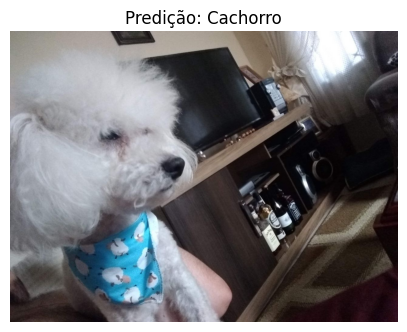

In [10]:
# Caminho para a pasta com as imagens de teste
folder_path = '/content/fotos_teste'

# Selecionar uma imagem aleatória da pasta
img_files = os.listdir(folder_path)
random_img = random.choice(img_files)
img_path = os.path.join(folder_path, random_img)

# Carregar e pré-processar a imagem
img_array = load_and_preprocess_image(img_path)

# Fazer a previsão
prediction = model.predict(img_array)

# Interpretar o resultado
label = "Cachorro" if prediction[0] > 0.5 else "Gato"

# Exibir a imagem e a predição
plt.figure(figsize=(5, 5))
img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f"Predição: {label}")
plt.axis("off")
plt.show()


In [11]:
# Prever no conjunto de validação
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Matriz de Confusão
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", conf_matrix)


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 592ms/step
Matriz de Confusão:
 [[224 276]
 [219 281]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


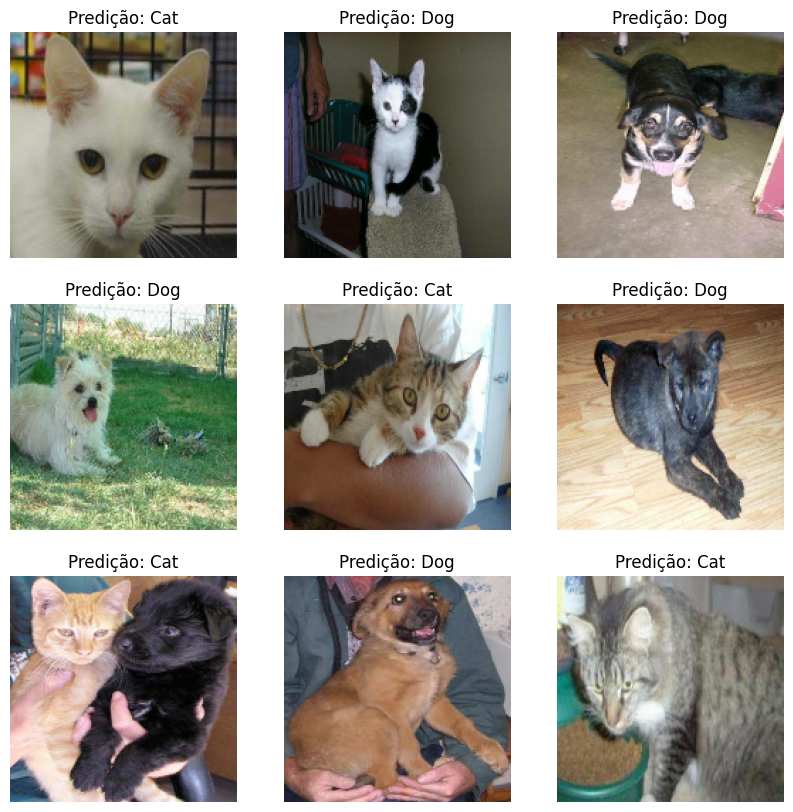

In [12]:
def display_image_predictions(dataset, model):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Pega um batch de imagens
        predictions = model.predict(images)
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = 'Dog' if predictions[i] > 0.5 else 'Cat'
            plt.title(f"Predição: {label}")
            plt.axis("off")
    plt.show()

display_image_predictions(validation_dataset, model)
